# Spleen 3D segmentation with MONAI

This tutorial shows how to integrate 3rd party transforms into MONAI program.  
Mainly shows transforms from `BatchGenerator`, `TorchIO` and `Rising`.

In [10]:
! pip install --upgrade batchgenerators

     |████████████████████████████████| 51kB 672kB/s eta 0:00:011
  Created wheel for batchgenerators: filename=batchgenerators-0.20.1-cp36-none-any.whl size=70315 sha256=f7e22438ec8c37ad29feb5f0d752c2778ba4acb6d22d31c3bf787a1b0537881a
  Stored in directory: /root/.cache/pip/wheels/da/6d/f4/6f4c4fcd88115a2e9963bd144b75e78d8ecc72e94e164d8b6b
Successfully built batchgenerators
  Found existing installation: batchgenerators 0.19.7
    Uninstalling batchgenerators-0.19.7:
      Successfully uninstalled batchgenerators-0.19.7


In [1]:
# Copyright 2020 MONAI Consortium
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#     http://www.apache.org/licenses/LICENSE-2.0
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

import os
import glob
import numpy as np
import torch
import matplotlib.pyplot as plt
import monai
from monai.transforms import \
    LoadNiftid, AddChanneld, ScaleIntensityRanged, CropForegroundd, \
    Spacingd, Orientationd, SqueezeDimd, ToTensord
from monai.utils import set_determinism
import batchgenerators
from batchgenerators.transforms.color_transforms import ContrastAugmentationTransform

## Set MSD Spleen dataset path

In [2]:
data_root = '/workspace/data/medical/Task09_Spleen'
train_images = sorted(glob.glob(os.path.join(data_root, 'imagesTr', '*.nii.gz')))
train_labels = sorted(glob.glob(os.path.join(data_root, 'labelsTr', '*.nii.gz')))
data_dicts = [{'image': image_name, 'label': label_name}
              for image_name, label_name in zip(train_images, train_labels)]

## Set deterministic training for reproducibility

In [3]:
set_determinism(seed=0)

## Setup MONAI transforms

In [4]:
monai_transforms = monai.transforms.Compose([
    LoadNiftid(keys=['image', 'label']),
    AddChanneld(keys=['image', 'label']),
    Spacingd(keys=['image', 'label'], pixdim=(1.5, 1.5, 2.), interp_order=(3, 0), mode='nearest'),
    Orientationd(keys=['image', 'label'], axcodes='RAS'),
    ScaleIntensityRanged(keys=['image'], a_min=-57, a_max=164, b_min=0.0, b_max=1.0, clip=True),
    CropForegroundd(keys=['image', 'label'], source_key='image'),
    AddChanneld(keys='image')  # add another dim as BatchGenerator expects shape [B, C, H, W, D]
])

## Setup BatchGenerator transforms
Problems with BatchGenerator:
1. BatchGenerator requires the arg is `**data`, can't compose with MONAI transforms.
2. BatchGenerator requires data shape is [B, C, H, W, D], MONAI requires [C, H, W, D].
3. As it can't be composed with MONAI transforms, so can't be compatible with our `CacheDataset`

In [5]:
batch_generator_transforms = batchgenerators.transforms.Compose([
    ContrastAugmentationTransform(data_key="image")
])

## Setup TorchIO transforms

## Setup Rising transforms

## Compose all transforms

In [6]:
end_transforms = monai.transforms.Compose([
    SqueezeDimd(keys='image', dim=0),
    ToTensord(keys=['image', 'label'])
])
def transform_func(data):
    data = monai_transforms(data)
    data = batch_generator_transforms(**data)
    return end_transforms(data)

## Check transforms in DataLoader

image shape: torch.Size([329, 282, 136]), label shape: torch.Size([329, 282, 136])


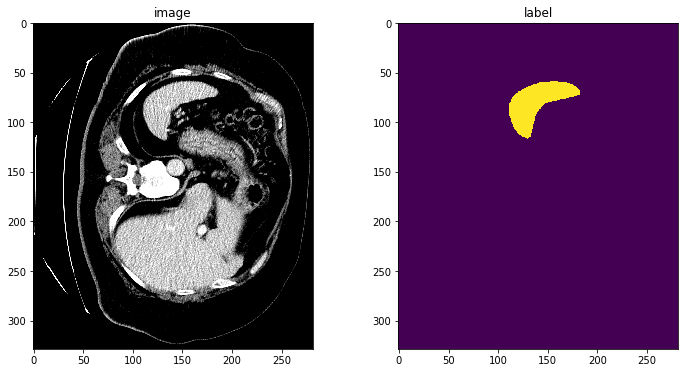

In [7]:
check_ds = monai.data.Dataset(data=data_dicts, transform=transform_func)
check_loader = monai.data.DataLoader(check_ds, batch_size=1)
check_data = monai.utils.misc.first(check_loader)
image, label = (check_data['image'][0][0], check_data['label'][0][0])
print('image shape: {}, label shape: {}'.format(image.shape, label.shape))
# plot the slice [:, :, 80]
plt.figure('check', (12, 6))
plt.subplot(1, 2, 1)
plt.title('image')
plt.imshow(image[:, :, 80], cmap='gray')
plt.subplot(1, 2, 2)
plt.title('label')
plt.imshow(label[:, :, 80])
plt.show()